# Predicting House Sale Prices

In this project our aim is to predict house sale prices using the linear regression model. We'll fit the model using two different approaches and use some techniques for cleaning, transforming and selecting features.

## Introduction

We'll work with housing data for the city of Ames, Iowa, United States of America from 2006 to 2010. You can read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

First of all we'll create some functions to select and transform features and to train and test the model. This way, we can use them  as a basis for experimenting and updating the functions. 

In [58]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

pd.options.display.max_columns = 100

In [59]:
#Reading the data into a dataframe
house = pd.read_csv("AmesHousing.tsv", delimiter="\t")

In [60]:
#Creating the function to transform the features
def transform_features(df):
    return df

#Creating the function to select the features
def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

#Creating the function to make predictions
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=["int", "float"])
    numeric_test = test.select_dtypes(include=["int", "float"])
    
    features = numeric_train.columns.drop(["SalePrice"])
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    rmse = mean_squared_error(test["SalePrice"], predictions) ** (1/2)
    
    return rmse

#Computing the rmse 
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house)

#Showing the result
rmse

57088.25161263909

## Feature Engineering

Now we'll update the *transform_features* function. In general, the goal of this function is to:

* **Remove** features that we don't want to use in the model, just based on the number on missing values or data leakage.
* **Transform** feautures into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc).
* **Create** new features by combining other features.

Let's drop any column with more than 5% of missing values.

In [61]:
#Finding the missing values
missing = house.isnull().sum()

#Filtering columns containing > 5% missing values
drop_missing = missing[missing > len(house)/20]

#Dropping those columns from the dataframe
house = house.drop(drop_missing.index, axis=1)

Now we'll remove any text column with one or more missing values.

In [62]:
#Finding the missing values
text_missing = house.select_dtypes(include=["object"]).isnull().sum()

#Filtering columns with at least 1 missing value
drop_text = text_missing[text_missing > 0]

#Dropping those columns from the dataframe
house = house.drop(drop_text.index, axis=1)

Let's fill the most common value in the numerical colums.

In [63]:
#Compute the missing value count
numerical_missing = house.select_dtypes(include=["int", "float"]).isnull().sum()
numerical_missing = numerical_missing[(numerical_missing < len(house)/20) & (numerical_missing > 0)]
numerical_missing

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [64]:
#Finding the most common value for each column in numerical_missing
mode_values = house[numerical_missing.index].mode()
mode_values = mode_values.to_dict("records")[0]
mode_values

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [65]:
#Replacing missing values
house = house.fillna(mode_values)

#Checking the missing values
house.isnull().sum().value_counts()

0    64
dtype: int64

Now we'll create a new feature that better capture the information in some of the features.

In [66]:
#Create new columns
house["Years Before Sale"] = house["Yr Sold"] - house["Year Built"]
house["Years Since Remod"] = house["Yr Sold"] - house["Year Remod/Add"]

#Selecting row with negative values
print(house["Years Before Sale"][house["Years Before Sale"] < 0], "\n")
print(house["Years Since Remod"][house["Years Since Remod"] < 0])

2180   -1
Name: Years Before Sale, dtype: int64 

1702   -1
2180   -2
2181   -1
Name: Years Since Remod, dtype: int64


In [67]:
#Removing these rows
house = house.drop([1702, 2180, 2181], axis=0)

#Removing the original years columns
house = house.drop(["Year Built", "Year Remod/Add"], axis=1)

Now we'll drop any column that isn't useful for Machine Learning and any column that leak data about the final sale.

In [68]:
## Drop columns that aren't useful for ML
house = house.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
house = house.drop(["Sale Type", "Mo Sold", "Sale Condition"], axis=1)

Let's update the function *transform_features* with the changes defined above.

In [69]:
def transform_features(df):
    missing = df.isnull().sum()
    drop_missing = missing[missing > len(df)/20]
    df = df.drop(drop_missing.index, axis=1)
    
    text_missing = df.select_dtypes(include=["object"]).isnull().sum()
    drop_text = text_missing[text_missing > 0]
    df = df.drop(drop_text.index, axis=1)
    
    numerical_missing = df.select_dtypes(include=["int", "float"]).isnull().sum()
    numerical_missing = numerical_missing[(numerical_missing < len(df)/20) & (numerical_missing > 0)]
    mode_values = df[numerical_missing.index].mode()
    mode_values = mode_values.to_dict("records")[0]
    df = df.fillna(mode_values)
    
    df["Years Before Sale"] = df["Yr Sold"] - df["Year Built"]
    df["Years Since Remod"] = df["Yr Sold"] - df["Year Remod/Add"]
    df = df.drop([1702, 2180, 2181], axis=0)
    
    df = df.drop(["Year Built", "Year Remod/Add", "PID", "Order","Sale Type", "Mo Sold", "Sale Condition"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=["int", "float"])
    numeric_test = test.select_dtypes(include=["int", "float"])
    
    features = numeric_train.columns.drop(["SalePrice"])
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    rmse = mean_squared_error(test["SalePrice"], predictions) ** (1/2)
    
    return rmse

house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house)

rmse

55275.36731241307

## Feature Selection

Now that we've cleaned and transformed a lot of the features in tha data set, it's time to move on to feature selection for numerical features. Let's start considering which features are strongly correlated with our target column.

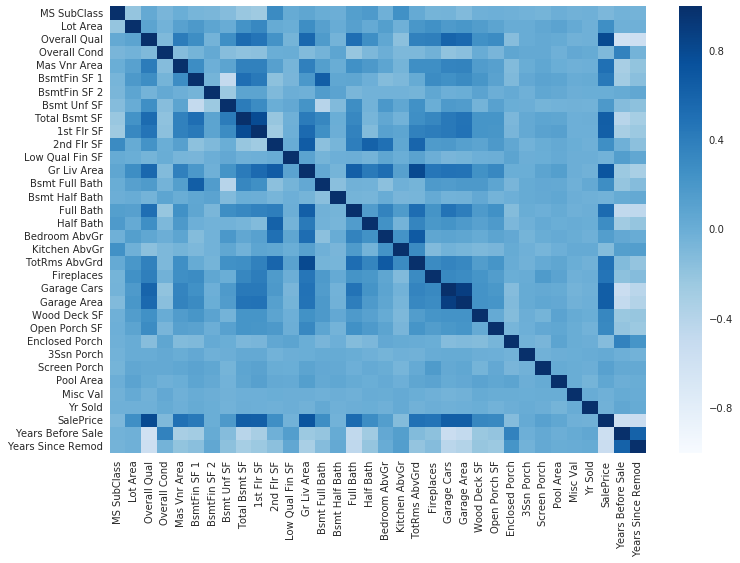

In [70]:
#Selecting numerical columns
numerical = transform_house.select_dtypes(["int", "float"])

#Creating a heatmap of the correlations
%matplotlib inline
plt.figure(figsize=(12, 8))
sns.heatmap(numerical.corr(), cmap="Blues")

In [71]:
#Computing the correlations with our target column
abs_corr = numerical.corr()["SalePrice"].abs().sort_values()
abs_corr

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

We'll only keep columns with a correlation coefficient larger than 0.4.

In [72]:
#Dropping columns with a correlation coefficient < 0.4
transform_house = transform_house.drop(abs_corr[abs_corr < 0.4].index, axis=1)

At this point we'll looking for columns that are currently numerical but need to be encoded as categorical instead, since the number don't have any semantic meaning. We'll also keep only the categorical columns with a maximum of 10 unique values, since when we dummy code these columns, we need to add too many columns back to the dataframe.

In [73]:
#Creating a list of categorical columns
nominal = ["MS SubClass", "MS Zoning", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
           "Condition 1", "PID", "Condition 2", "Bldg Type", "House Style", "Roof Style", 
           "Roof Matl", "Exterior 1st", "Exterior ","Misc Feature", "Street", "Sale Type", "Sale Condition"]

#Choosing nominal columns in transform_house
transform_col = []
for column in nominal:
    if column in transform_house.columns:
        transform_col.append(column)

#Dropping columns with more than 10 unique values
counts = transform_house[transform_col].apply(lambda col: len(col.value_counts()))
transform_house = transform_house.drop(counts[counts > 10].index, axis=1)

#Converting the remaining text columns to categorical
text = transform_house.select_dtypes(include=["object"])
for col in text:
    transform_house[col] = transform_house[col].astype('category')

#Creating dummy columns
transform_house = pd.concat([transform_house, pd.get_dummies(transform_house.select_dtypes(include=['category']))], axis=1).drop(text,axis=1)

## Train and Test

The next step is to update the logic for the *select_features* function and we'll add a parameter named *k*, in the *train_and_test* function, that controls the type of cross validation that we want to perform.

In [74]:
def transform_features(df):
    missing = df.isnull().sum()
    drop_missing = missing[missing > len(df)/20]
    df = df.drop(drop_missing.index, axis=1)
    
    text_missing = df.select_dtypes(include=["object"]).isnull().sum()
    drop_text = text_missing[text_missing > 0]
    df = df.drop(drop_text.index, axis=1)
    
    numerical_missing = df.select_dtypes(include=["int", "float"]).isnull().sum()
    numerical_missing = numerical_missing[(numerical_missing < len(df)/20) & (numerical_missing > 0)]
    mode_values = df[numerical_missing.index].mode()
    mode_values = mode_values.to_dict("records")[0]
    df = df.fillna(mode_values)
    
    df["Years Before Sale"] = df["Yr Sold"] - df["Year Built"]
    df["Years Since Remod"] = df["Yr Sold"] - df["Year Remod/Add"]
    df = df.drop([1702, 2180, 2181], axis=0)
    
    df = df.drop(["Year Built", "Year Remod/Add", "PID", "Order","Sale Type", "Mo Sold", "Sale Condition"], axis=1)
    return df

def select_features(df, coeff_value=0.4, unique=10):
    numerical = df.select_dtypes(["int", "float"])
    abs_corr = numerical.corr()["SalePrice"].abs().sort_values()
    df = df.drop(abs_corr[abs_corr < coeff_value].index, axis=1)
    
    nominal = ["MS SubClass", "MS Zoning", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
           "Condition 1", "PID", "Condition 2", "Bldg Type", "House Style", "Roof Style", 
           "Roof Matl", "Exterior 1st", "Exterior ","Misc Feature", "Street", "Sale Type", "Sale Condition"]

    transform_col = []
    for column in nominal:
        if column in df.columns:
            transform_col.append(column)

    counts = df[transform_col].apply(lambda col: len(col.value_counts()))
    df = df.drop(counts[counts > unique].index, axis=1)

    text = df.select_dtypes(include=["object"])
    for col in text:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric = df.select_dtypes(include=["int", "float"])
    features = numeric.columns.drop(["SalePrice"])
    lr = LinearRegression()
    
    if k==0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        rmse = mean_squared_error(test["SalePrice"], predictions) ** (1/2)

        return rmse
    
    if k==1:
        shuffled = df.sample(frac=1, random_state=1 )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        rmse_one = (mean_squared_error(test["SalePrice"], predictions_one)) ** (1/2)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        rmse_two = mean_squared_error(train["SalePrice"], predictions_two) ** (1/2)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            rmse = mean_squared_error(test["SalePrice"], predictions) ** (1/2)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house, k=4)

rmse

[33232.23001600172, 33101.724276194815, 36988.90399938383, 40137.94818823223]


35865.20161995315